In [17]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import interpolations_cffi

In [18]:

# with open('data_to_python_plain.txt') as fp:
#     line = fp.readline()
#     while line:
#         exec(line)
#         line = fp.readline()

# np.savez_compressed('LUT_id',Vec_th=Vec_th,Vec_fluxd=Vec_fluxd, Vec_fluxq=Vec_fluxq, LUT_id=LUT_id)
# np.savez_compressed('LUT_iq',Vec_th=Vec_th,Vec_fluxd=Vec_fluxd, Vec_fluxq=Vec_fluxq, LUT_iq=LUT_iq)
# np.savez_compressed('LUT_Te',Vec_th=Vec_th,Vec_fluxd=Vec_fluxd, Vec_fluxq=Vec_fluxq, LUT_Te=LUT_Te)

In [19]:
LUT_id_data = np.load('LUT_id.npz')
LUT_iq_data = np.load('LUT_iq.npz')
LUT_Te_data = np.load('LUT_Te.npz')

Vec_th = LUT_id_data['Vec_th']
Vec_fluxd = LUT_id_data['Vec_fluxd']
Vec_fluxq = LUT_id_data['Vec_fluxq']
LUT_id = LUT_id_data['LUT_id']
LUT_iq = LUT_iq_data['LUT_iq']
LUT_Te = LUT_Te_data['LUT_Te']

ffi = interpolations_cffi.ffi 

Vec_th_ptr = ffi.cast("double *", ffi.from_buffer(Vec_th))
Vec_fluxd_ptr = ffi.cast("double *", ffi.from_buffer(Vec_fluxd))
Vec_fluxq_ptr = ffi.cast("double *", ffi.from_buffer(Vec_fluxq))
LUT_id_ptr = ffi.cast("double *", ffi.from_buffer(LUT_id))  # Adjust type if needed
LUT_iq_ptr = ffi.cast("double *", ffi.from_buffer(LUT_iq))  # Adjust type if needed
LUT_Te_ptr = ffi.cast("double *", ffi.from_buffer(LUT_Te))  # Adjust type if needed

Vec_fluxd_max = np.max(Vec_fluxd)
Vec_fluxd_min = np.min(Vec_fluxd)
Vec_fluxq_max = np.max(Vec_fluxq)
Vec_fluxq_min = np.min(Vec_fluxq)

In [ ]:
max_index = np.unravel_index(np.argmax(LUT_Te), (180,31,31))
max_index

(179, 27, 15)

In [ ]:
#double interp3(double x, double y, double z, double *xVec, int xVec_n, double *yVec, int yVec_n, double *zVec, int zVec_n, double *LUT);
interpolations_cffi.lib.interp3(0,Vec_fluxd_max,0, Vec_th_ptr,len(Vec_th),Vec_fluxd_ptr,len(Vec_fluxd),Vec_fluxq_ptr,len(Vec_fluxq),LUT_Te_ptr)

0.1025465908380094

In [23]:

# Generate data
theta = 358
N_x = 100
N_y = 100
fluxd = np.linspace(Vec_fluxd_min, Vec_fluxd_max, N_x)
fluxq = np.linspace(Vec_fluxq_min, Vec_fluxq_max, N_y)
fluxd_mesh, fluxq_mesh = np.meshgrid(fluxd, fluxq)

Te_mesh = np.zeros(fluxd_mesh.shape)
i_d_mesh = np.zeros(fluxd_mesh.shape)
i_q_mesh = np.zeros(fluxd_mesh.shape)

for ix in range(N_x):
    for iy in range(N_y):
            x = fluxd_mesh[ix,iy]
            y = fluxq_mesh[ix,iy]
            i_d_mesh[ix,iy] = interpolations_cffi.lib.interp3(x,y,theta, Vec_fluxd_ptr,len(Vec_fluxd),Vec_fluxq_ptr,len(Vec_fluxq),Vec_th_ptr,len(Vec_th),LUT_id_ptr)
            i_q_mesh[ix,iy] = interpolations_cffi.lib.interp3(x,y,theta, Vec_fluxd_ptr,len(Vec_fluxd),Vec_fluxq_ptr,len(Vec_fluxq),Vec_th_ptr,len(Vec_th),LUT_iq_ptr)
            Te_mesh[ix,iy]  = interpolations_cffi.lib.interp3(x,y,theta, Vec_fluxd_ptr,len(Vec_fluxd),Vec_fluxq_ptr,len(Vec_fluxq),Vec_th_ptr,len(Vec_th),LUT_Te_ptr)

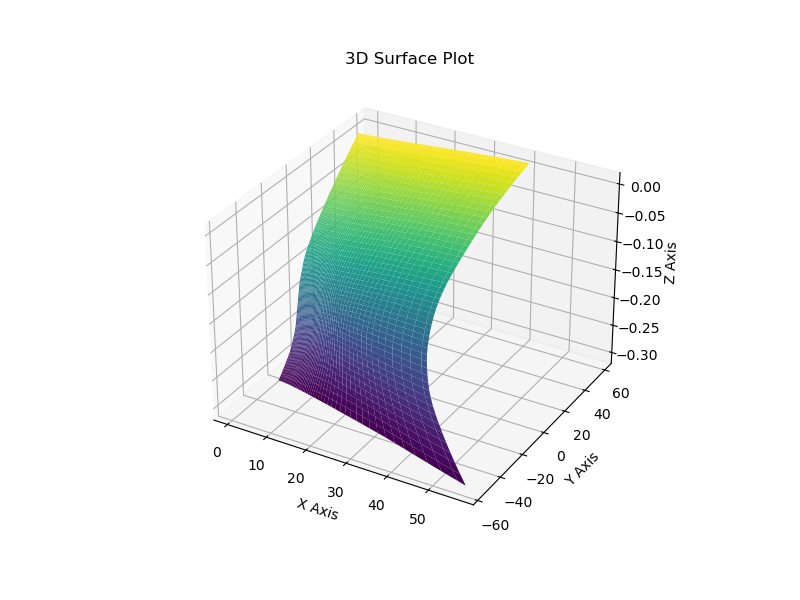

In [27]:
# Create 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
ax.plot_surface(i_d_mesh,i_q_mesh, fluxq_mesh, cmap='viridis')

# Labels
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("3D Surface Plot")

# Show plot
plt.show()

In [ ]:
def array2str(X):
    string = ''
    it_col = 0
    it_row = 0
    tab = ''
    for it,value in enumerate(X):
        string += f'{value:0.6g}, '
        if it_col > 50:
            it_col = 0
            it_row += 1
            string += f'\n'
            string += ' '*20
        it_col +=1
    X_string = string[:-2]
    N_x = it+1

    return X_string,N_x

In [ ]:
string = '''
#include <stdio.h>
#include <math.h>

double Flux2id(double t, double theta, double phi_d, double phi_q){

    static double Vec_th[{N_Vec_th}] = {{Vec_th}};
    static double Vec_fluxd[{N_Vec_fluxd}] = {{Vec_fluxd}};
    static double Vec_fluxq[{N_Vec_fluxq}] = {{Vec_fluxq}};
    static double LUT_id[{N_LUT_id}] = {{LUT_id}};

    return interp3(phi_d, phi_q, theta, Vec_fluxd, {N_Vec_fluxd}, Vec_fluxq, {N_Vec_fluxq}, Vec_th, {N_Vec_th}, LUT_id);
    
}

double Flux2iq(double t, double theta, double phi_d, double phi_q){

    static double Vec_th[{N_Vec_th}] = {{Vec_th}};
    static double Vec_fluxd[{N_Vec_fluxd}] = {{Vec_fluxd}};
    static double Vec_fluxq[{N_Vec_fluxq}] = {{Vec_fluxq}};
    static double LUT_iq[{N_LUT_iq}] = {{LUT_iq}};

    return interp3(phi_d, phi_q, theta, Vec_fluxd, {N_Vec_fluxd}, Vec_fluxq, {N_Vec_fluxq}, Vec_th, {N_Vec_th}, LUT_iq);

}

double Flux2Te(double t, double theta, double phi_d, double phi_q){

    static double Vec_th[{N_Vec_th}] = {{Vec_th}};
    static double Vec_fluxd[{N_Vec_fluxd}] = {{Vec_fluxd}};
    static double Vec_fluxq[{N_Vec_fluxq}] = {{Vec_fluxq}};
    static double LUT_Te[{N_LUT_Te}] = {{LUT_Te}};

    return interp3(phi_d, phi_q, theta, Vec_fluxd, {N_Vec_fluxd}, Vec_fluxq, {N_Vec_fluxq}, Vec_th, {N_Vec_th}, LUT_Te);

}
'''

In [ ]:
for item_name,item in [('Vec_th',Vec_th),
             ('Vec_fluxd',Vec_fluxd),
             ('Vec_fluxq',Vec_fluxq),
             ('LUT_id',LUT_id),
             ('LUT_iq',LUT_iq),
             ('LUT_Te',LUT_Te)]:
    
    X_string,N_x = array2str(item)
    string = string.replace('{N_' + item_name +  '}',str(N_x))
    string = string.replace('{' + item_name +  '}',X_string)


with open('machine.c','w') as fobj:
    fobj.write(string)

In [ ]:
c_Vec_th = np.array2string(Vec_th).replace("{ ","{")
string = string.replace('{N_Vec_th}',str(len(Vec_th)))
string = string.replace('{Vec_th}',c_Vec_th)

c_LUT_id = np.array2string(LUT_id).replace("{ ","{")
string = string.replace('{N_LUT_id}',str(len(LUT_id)))
string = string.replace('{LUT_id}',c_LUT_id)



In [ ]:
print(string)


#include <stdio.h>
#include <math.h>

double PWM(double t, double theta, double phi_d, double phi_q){
    double Vec_th[180] = [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278.
 280. 282. 284. 286. 288. 290. 292. 294. 296. 298. 300. 302. 304. 306.
 308. 310. 312. 314. 316. 318. 320. 322. 324. 326. 328. 330. 332. 334.
 336. 338. 340. 342.

0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 
44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 
86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 
128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 
170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 
212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 
254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 
296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 
338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358
